In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import explained_variance_score
import matplotlib
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("data/count and temperature 1997-2019.csv")

In [3]:
new_df = df[df["total"]!=0].copy(deep = True).reset_index()

In [4]:
df["total"].shape

(8400,)

In [5]:
mu, sigma = 0, 0.1
noise = np.random.normal(mu, sigma, [df.shape[0],]) 
df["noised_total"]=df["total"]+noise

In [6]:
conditions = [df["season"]=="Spring",df["season"]=="Summer",df["season"]=="Fall",df["season"]=="Winter"]
values = ["green", "steelblue","gold","tomato"]

In [7]:
df["colors"] = np.select(conditions,values)

In [8]:
df

,date,total,tmin,tmax,year,month,day,avg,season,noised_total,colors
0,1997-01-01,0,28,33,1997,1,1,30.5,Winter,0.100987,tomato
1,1997-01-02,1,32,42,1997,1,2,37.0,Winter,1.204452,tomato
2,1997-01-03,0,31,38,1997,1,3,34.5,Winter,-0.104606,tomato
3,1997-01-04,0,35,39,1997,1,4,37.0,Winter,-0.022613,tomato
4,1997-01-05,0,9,35,1997,1,5,22.0,Winter,0.098339,tomato
...,...,...,...,...,...,...,...,...,...,...,...
8395,2019-12-27,0,22,38,2019,12,27,30.0,Winter,0.186712,tomato
8396,2019-12-28,0,21,42,2019,12,28,31.5,Winter,0.061428,tomato
8397,2019-12-29,0,42,54,2019,12,29,48.0,Winter,-0.005630,tomato
8398,2019-12-30,0,24,42,2019,12,30,33.0,Winter,-0.089029,tomato


(-0.5, 12.0)

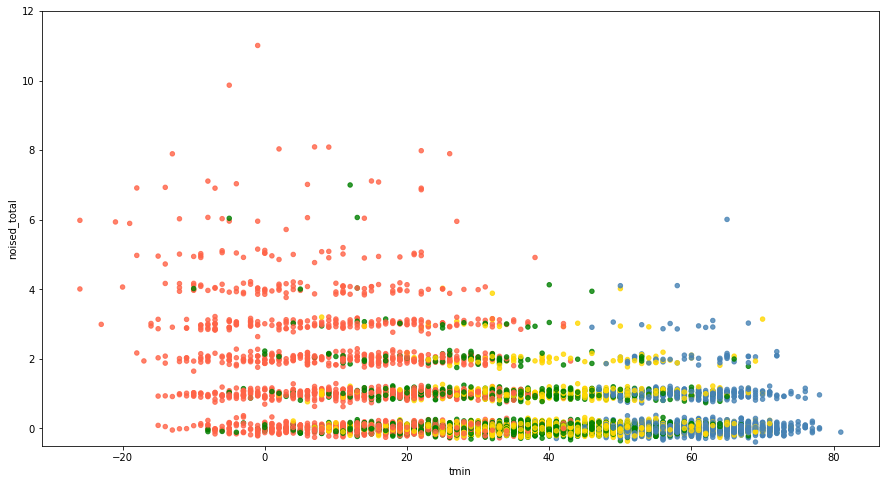

In [9]:
fig,ax = plt.subplots(figsize = (15,8))
df.plot.scatter(x = "tmin", y = "noised_total",color = df["colors"],ax=ax,alpha = 0.8)
ax.set_ylim((-0.5,12))

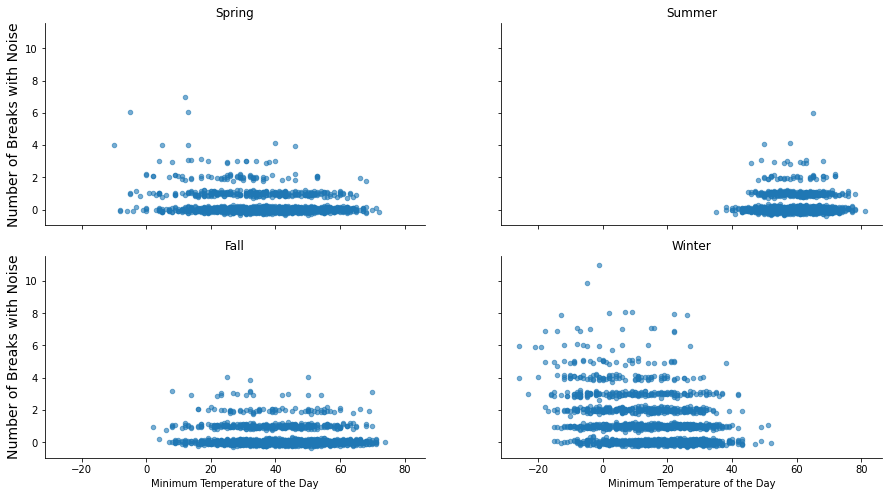

In [10]:
fig,axes = plt.subplots(2,2,figsize = (15,8),sharex = True,sharey=True)
plt.subplots_adjust(hspace = 0.15)
axes = list(axes.reshape(-1))
for s in ["Spring","Summer","Fall","Winter"]:
    ax = axes.pop(0)
    ax.set_title(s)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    season_df = df[df["season"]==s]
    season_df.plot.scatter(x = "tmin", y = "noised_total",ax=ax,alpha = 0.6)
    ax.set_xlabel("Minimum Temperature of the Day")
    ax.set_ylabel("Number of Breaks with Noise",fontsize = 14)
#plt.savefig("break pattern by season")

In [11]:
class OneHot(TransformerMixin):
    def __init__(self,col):
        self.col = col
        self.oh = OneHotEncoder()
    
    def fit(self,x,y=None):
        self.oh.fit(x[[self.col]])
        return self
    
    def transform(self,x):
        ones = self.oh.transform(x[[self.col]])
        ones = pd.DataFrame(ones.toarray(),columns = self.oh.get_feature_names(),index = x.index)
        return pd.concat((x.drop(columns = [self.col]),ones),axis = 1)

In [12]:
train,test = train_test_split(df,stratify = df["season"],train_size = 0.5)

In [13]:
oh = OneHot("season")
data = oh.fit_transform(train[["tmin","season"]])

In [14]:
p = Pipeline([
    ("onehot",OneHot("season")),
    ("poly",PolynomialFeatures(2)),
    ("lr",LinearRegression())
])
p.fit(train[["tmin","season"]],train["total"])
(explained_variance_score(train["total"],p.predict(train[["tmin","season"]])),
explained_variance_score(test["total"],p.predict(test[["tmin","season"]])))

(0.22931703771109901, 0.2600630576757885)

In [15]:
p["lr"].coef_,p["lr"].intercept_

(array([ 0.00000000e+00, -2.83767194e-02, -1.74861911e-01, -1.68164867e-01,
         1.01428260e-01,  2.41598518e-01,  3.25445264e-04,  4.28364338e-05,
        -1.63917827e-03, -1.08513329e-02, -1.59290447e-02, -1.74861911e-01,
        -7.02050531e-43,  1.26116862e-44,  0.00000000e+00, -1.68164867e-01,
        -9.33452292e-61, -3.88938455e-62,  1.01428260e-01,  0.00000000e+00,
         2.41598518e-01]),
 1.1707699440585857)

Text(0, 0.5, 'The Number of Water Main Breaks')

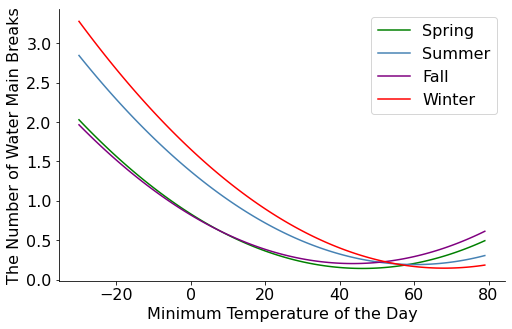

In [16]:
#temp_range= {"Spring":np.arange(-10,70,1),"Summer":np.arange(30,80,1),"Fall":np.arange(0,70,1),"Winter":np.arange(-30,50,1)}
matplotlib.rcParams.update({"font.size":16})
colors = ["green","steelblue","purple","red"]
def plot_season(season,ax):
    df = pd.DataFrame({
        "season":season,
        "tmin": np.arange(-30,80,1),
    })
    df["predicted_breaks"] = p.predict(df)
    ax = df.plot.line(x="tmin",y="predicted_breaks",label = name, color = colors.pop(0), ax=ax)
    return ax

fig,ax = plt.subplots(figsize = (8,5))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
for name in ["Spring","Summer","Fall","Winter"]:
    ax = plot_season(name,ax)
ax.set_xlabel("Minimum Temperature of the Day")
ax.set_ylabel("The Number of Water Main Breaks")
#plt.savefig("break prediction given temp and season.pdf")

In [17]:
# next_day_tmax = df["tmax"][1:].reset_index().drop("index",axis = "columns")
# next_day_tmax.loc[8399,"tmax"]=0
# next_day_tmax=next_day_tmax.rename(columns={"tmax": "next_day_tmax"})
# df["next_day_tmax"]=next_day_tmax["next_day_tmax"]

In [18]:
prev_day_tmin = df["tmin"][:-1]
prev_day_tmin = np.array([0]+list(prev_day_tmin.values))
df["prev_day_tmin"] = prev_day_tmin
#df["change_temp"]=df["tmax"]-df["prev_day_tmin"]
df["change_temp"]=df["tmin"]-df["prev_day_tmin"]
#df["mag_change"] = abs(df["change_temp"])
df = df.drop(0,axis = 0)
df

,date,total,tmin,tmax,year,month,day,avg,season,noised_total,colors,prev_day_tmin,change_temp
1,1997-01-02,1,32,42,1997,1,2,37.0,Winter,1.204452,tomato,28,4
2,1997-01-03,0,31,38,1997,1,3,34.5,Winter,-0.104606,tomato,32,-1
3,1997-01-04,0,35,39,1997,1,4,37.0,Winter,-0.022613,tomato,31,4
4,1997-01-05,0,9,35,1997,1,5,22.0,Winter,0.098339,tomato,35,-26
5,1997-01-06,0,5,19,1997,1,6,12.0,Winter,0.083827,tomato,9,-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,2019-12-27,0,22,38,2019,12,27,30.0,Winter,0.186712,tomato,34,-12
8396,2019-12-28,0,21,42,2019,12,28,31.5,Winter,0.061428,tomato,22,-1
8397,2019-12-29,0,42,54,2019,12,29,48.0,Winter,-0.005630,tomato,21,21
8398,2019-12-30,0,24,42,2019,12,30,33.0,Winter,-0.089029,tomato,42,-18


In [19]:
train,test = train_test_split(df,stratify = df["season"],train_size = 0.5)

In [20]:
min_max = Pipeline([
    ("onehot",OneHot("season")),
    ("poly",PolynomialFeatures(2)),
    ("lr",LinearRegression())
])
min_max.fit(train[["tmin","tmax","season"]],train["total"])
(explained_variance_score(train["total"],min_max.predict(train[["tmin","tmax","season"]])),
explained_variance_score(test["total"],min_max.predict(test[["tmin","tmax","season"]])))

(0.2430636673846498, 0.24778766593651147)

In [21]:
max_ = Pipeline([
    ("onehot",OneHot("season")),
    ("poly",PolynomialFeatures(2)),
    ("lr",LinearRegression())
])
max_.fit(train[["tmax","season"]],train["total"])
(explained_variance_score(train["total"],max_.predict(train[["tmax","season"]])),
explained_variance_score(test["total"],max_.predict(test[["tmax","season"]])))

(0.23233240540624844, 0.22997449483096644)

In [22]:
all_ = Pipeline([
    ("onehot",OneHot("season")),
    ("poly",PolynomialFeatures(3)),
    ("lr",LinearRegression())
])
all_.fit(train[["tmin","tmax","change_temp","season"]],train["total"])
(explained_variance_score(train["total"],all_.predict(train[["tmin","tmax","change_temp","season"]])),
explained_variance_score(test["total"],all_.predict(test[["tmin","tmax","change_temp","season"]])))

(0.2520818276780583, 0.2509218314981171)

In [23]:
change = Pipeline([
    ("onehot",OneHot("season")),
    ("poly",PolynomialFeatures(3)),
    ("lr",LinearRegression())
])
change.fit(train[["tmin","change_temp","season"]],train["total"])
(explained_variance_score(train["total"],change.predict(train[["tmin","change_temp","season"]])),
explained_variance_score(test["total"],change.predict(test[["tmin","change_temp","season"]])))

(0.2504565531283488, 0.2514066906955882)